In [ ]:
import os
from google.colab import files

# Upload kaggle.json file
files.upload()

# Set up Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



Saving kaggle (1).json to kaggle (1).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!mv "kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d ninadaithal/imagesoasis
!unzip imagesoasis.zip -d "/content/oasis_dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_102.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_103.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_104.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: /content/oasis_dataset/Data/Very mil

In [ ]:
data_dir = "/content/oasis_dataset/Data"


In [ ]:
import os

# Recursively list files in the Data folder
for root, dirs, files in os.walk("/content/oasis_dataset/Data"):
    if files:  # Only print directories with files
        print(f"📁 Directory: {root}")
        print(f"   📄 Files: {files[:5]}")  # Display first 5 files for each directory
        print()


📁 Directory: /content/oasis_dataset/Data/Moderate Dementia
   📄 Files: ['OAS1_0351_MR1_mpr-4_117.jpg', 'OAS1_0308_MR1_mpr-4_145.jpg', 'OAS1_0351_MR1_mpr-3_118.jpg', 'OAS1_0351_MR1_mpr-4_143.jpg', 'OAS1_0351_MR1_mpr-3_152.jpg']

📁 Directory: /content/oasis_dataset/Data/Very mild Dementia
   📄 Files: ['OAS1_0380_MR1_mpr-2_105.jpg', 'OAS1_0015_MR1_mpr-2_102.jpg', 'OAS1_0066_MR1_mpr-2_106.jpg', 'OAS1_0243_MR1_mpr-3_137.jpg', 'OAS1_0016_MR1_mpr-2_120.jpg']

📁 Directory: /content/oasis_dataset/Data/Mild Dementia
   📄 Files: ['OAS1_0031_MR1_mpr-3_130.jpg', 'OAS1_0373_MR1_mpr-2_134.jpg', 'OAS1_0052_MR1_mpr-3_118.jpg', 'OAS1_0122_MR1_mpr-3_123.jpg', 'OAS1_0134_MR1_mpr-4_116.jpg']

📁 Directory: /content/oasis_dataset/Data/Non Demented
   📄 Files: ['OAS1_0227_MR1_mpr-1_118.jpg', 'OAS1_0117_MR2_mpr-3_144.jpg', 'OAS1_0241_MR1_mpr-2_156.jpg', 'OAS1_0038_MR1_mpr-3_123.jpg', 'OAS1_0253_MR1_mpr-4_104.jpg']



# preprocessing

In [ ]:
import os
import random
import shutil

# Parameters
sample_size_per_class = 20000  # Change this to however many images per class you want
original_dir = "/content/oasis_dataset/Data"
sample_dir = "/content/oasis_dataset/sample_data"

# Create the sample directory
os.makedirs(sample_dir, exist_ok=True)

# Loop over each class
for class_dir in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_dir)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)

    # Pick the minimum between sample size and available images
    num_to_sample = min(sample_size_per_class, len(images))
    sample_images = random.sample(images, num_to_sample)

    class_sample_dir = os.path.join(sample_dir, class_dir)
    os.makedirs(class_sample_dir, exist_ok=True)

    for image in sample_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(class_sample_dir, image)
        shutil.copy(src, dst)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
img_height, img_width = 128, 128  # Adjust image size if needed
batch_size = 32

# Set up ImageDataGenerator for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=40,     # Random rotations
    width_shift_range=0.2, # Random horizontal shifts
    height_shift_range=0.2,# Random vertical shifts
    shear_range=0.2,       # Shear transformations
    zoom_range=0.2,        # Zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'    # Fill pixels after transformations
)

# Training data generator (point to the sample directory)
train_gen = datagen.flow_from_directory(
    sample_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use the 80% for training
)

# Validation data generator (point to the sample directory)
val_gen = datagen.flow_from_directory(
    sample_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use the 20% for validation
)

# Retrieve class indices for model interpretation
class_indices = train_gen.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}


Found 31373 images belonging to 4 classes.
Found 7842 images belonging to 4 classes.


# model 2 three conv layers, batch normalization, and SGD optimizer

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.optimizers import SGD
#model 2 three conv layers batch norm and and sgd optimizer
input_tensor = Input(shape=(img_height, img_width, 3))

x = Conv2D(32, (3, 3), padding='same')(input_tensor)
x = ReLU()(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_tensor = Dense(len(train_gen.class_indices), activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289,092 (16.36 MB)

 Trainable params: 4,288,644 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_steps=val_gen.samples // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
980/980 ━━━━━━━━━━━━━━━━━━━━ 204s 201ms/step - accuracy: 0.4952 - loss: 1.4496 - val_accuracy: 0.5103 - val_loss: 1.0301
Epoch 2/10
  1/980 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.4375 - loss: 0.9797

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


980/980 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.4375 - loss: 0.9797 - val_accuracy: 0.5111 - val_loss: 1.0302
Epoch 3/10
980/980 ━━━━━━━━━━━━━━━━━━━━ 190s 194ms/step - accuracy: 0.5079 - loss: 1.0355 - val_accuracy: 0.5111 - val_loss: 1.0288
Epoch 4/10
980/980 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.4688 - loss: 1.2084 - val_accuracy: 0.5102 - val_loss: 1.0288
Epoch 5/10
980/980 ━━━━━━━━━━━━━━━━━━━━ 192s 195ms/step - accuracy: 0.5064 - loss: 1.0431 - val_accuracy: 0.5105 - val_loss: 1.0289
Epoch 6/10
980/980 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.4375 - loss: 1.0466 - val_accuracy: 0.5097 - val_loss: 1.0285
Epoch 7/10
980/980 ━━━━━━━━━━━━━━━━━━━━ 190s 194ms/step - accuracy: 0.5100 - loss: 1.0280 - val_accuracy: 0.5103 - val_loss: 1.0278
Epoch 8/10
980/980 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.6562 - loss: 0.9578 - val_accuracy: 0.5101 - val_loss: 1.0284
Epoch 9/10
980/980 ━━━━━━━━━━━━━━━━━━━━ 268s 242ms/step - accuracy: 0.5101 - loss: 1.0290 - val

# evaluation

In [ ]:
loss, accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


246/246 ━━━━━━━━━━━━━━━━━━━━ 38s 155ms/step - accuracy: 0.5074 - loss: 1.0303
Validation Loss: 1.0275
Validation Accuracy: 0.5105


# explainability techniques

In [ ]:
!pip install lime shap
import numpy as np
from lime import lime_image
from tensorflow.keras.preprocessing import image
from skimage import transform


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=24ee129e5beabf5f91486d857dfafae79cdb2a799efbf194c1f42d734f578508
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


lime

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

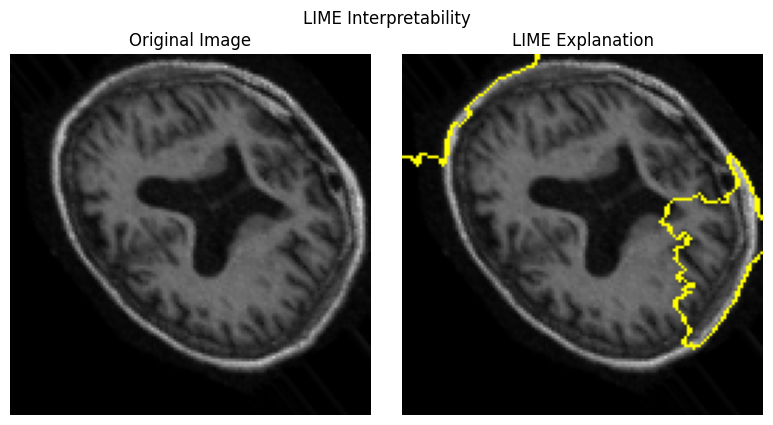

In [ ]:
val_images, val_labels = next(val_gen)
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()


image = val_images[0]


def predict_fn(images):
    return model.predict(images)

# Explain the prediction
explanation = explainer.explain_instance(
    image.astype('double'),
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)


temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=5,
    min_weight=0.0
)


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.tight_layout()
plt.suptitle("LIME Interpretability", y=1.05)
plt.show()


shap

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_137
Received: inputs=['Tensor(shape=(32, 128, 128, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_137
Received: inputs=['Tensor(shape=(64, 128, 128, 3))']
  warnings.warn(msg)


Shape of shap_values: 1, (128, 128, 3, 4)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_137
Received: inputs=['Tensor(shape=(1, 128, 128, 3))']
  warnings.warn(msg)


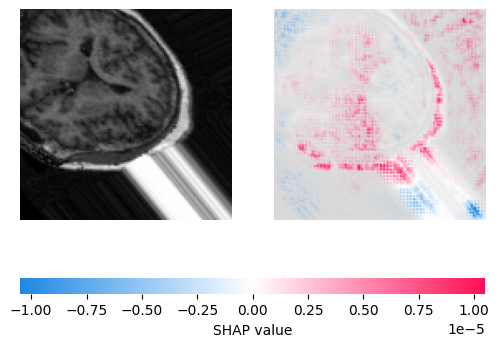

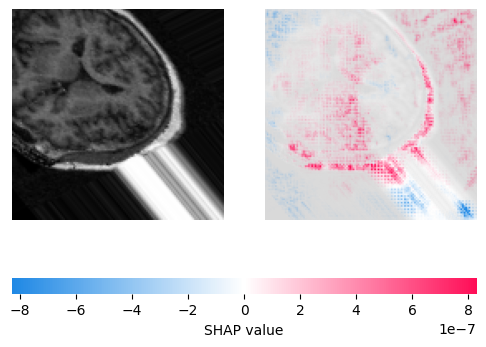

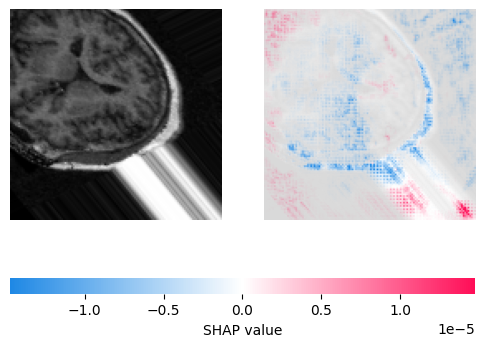

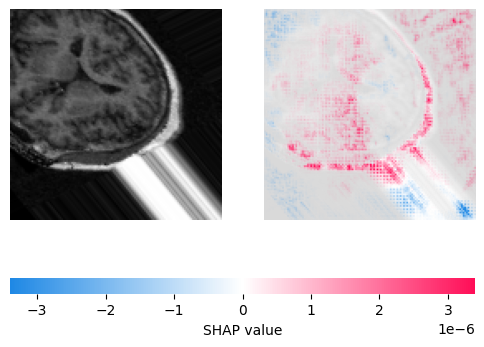

In [ ]:
import shap
import numpy as np

image_batch, label_batch =next(val_gen)

image_idx = np.random.randint(0, len(image_batch))
image_to_explain = image_batch[image_idx]

explainer = shap.DeepExplainer(model, image_batch[:100])

shap_values = explainer.shap_values(image_to_explain.reshape(1, img_height, img_width, 3))

print(f"Shape of shap_values: {len(shap_values)}, {shap_values[0].shape if len(shap_values) > 0 else 'None'}")


if len(shap_values) > 0:
    for class_idx in range(shap_values[0].shape[-1]):
        shap.image_plot([shap_values[0][:, :, :, class_idx]], image_to_explain)
else:
    print("No SHAP values available for visualization.")


Grad-Cam

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_17']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


Heatmap is all zeros after ReLU.


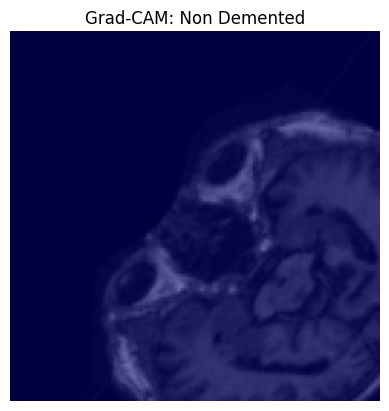

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def grad_cam(model, image, class_idx, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    if grads is None:
        print("Gradient is None. Check the model and inputs.")
        return np.zeros((image.shape[1], image.shape[2]))

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    max_val = np.max(heatmap)
    if max_val == 0:
        print("Heatmap is all zeros after ReLU.")
        return np.zeros((image.shape[1], image.shape[2]))

    heatmap /= max_val
    heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[1]))
    return heatmap


image_batch, label_batch = next(val_gen)
image_idx = np.random.randint(0, image_batch.shape[0])
image_to_explain = np.expand_dims(image_batch[image_idx], axis=0)

predicted_class_idx = np.argmax(model.predict(image_to_explain))

heatmap = grad_cam(model, image_to_explain, predicted_class_idx, last_conv_layer_name='conv2d_5')

plt.imshow(image_to_explain[0])
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title(f"Grad-CAM: {idx_to_class[predicted_class_idx]}")
plt.axis('off')
plt.show()


sailency map

In [ ]:
def saliency_map(model, image, class_idx):
    image_tensor = tf.convert_to_tensor(image)
    image_tensor = tf.cast(image_tensor, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        predictions = model(image_tensor, training=False)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, image_tensor)

    if grads is None:
        print("Gradients are None.")
        return np.zeros((image.shape[1], image.shape[2]))

    # Use absolute gradient magnitude (no ReLU)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    saliency = saliency.numpy()
    max_val = np.max(saliency)
    if max_val == 0:
        print("Saliency map still all zeros.")
        return np.zeros((image.shape[1], image.shape[2]))

    saliency /= max_val
    return saliency


Saliency map still all zeros.


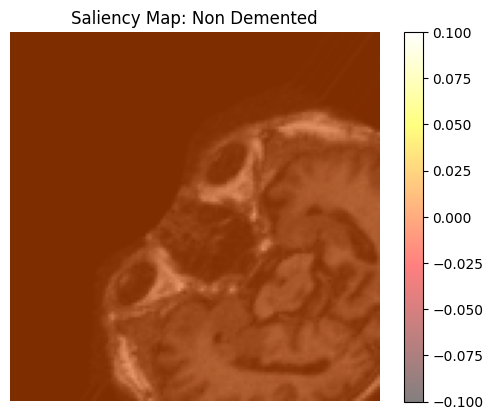

In [ ]:
saliency = saliency_map(model, image_to_explain, predicted_class_idx)

plt.imshow(image_to_explain[0])
plt.imshow(saliency, cmap='hot', alpha=0.5)
plt.title(f"Saliency Map: {idx_to_class[predicted_class_idx]}")
plt.axis('off')
plt.colorbar()
plt.show()